In [1]:
from src import  subfunc as sf
import catboost
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import  warnings
from tqdm import  tqdm

In [19]:
DATA_PATH = '../../data/'
FINAL_STAGE = 'final_stage/'
SOURCE_DIR = '../../source/'
warnings.filterwarnings("ignore")

In [3]:
X_train = pd.read_csv(f'{DATA_PATH}{FINAL_STAGE}x_train.csv',sep='\t', index_col='index')
X_test = pd.read_csv(f'{DATA_PATH}{FINAL_STAGE}x_test.csv', sep='\t', index_col='index')
y_train = pd.read_csv(f'{DATA_PATH}{FINAL_STAGE}y_train.csv',sep='\t', index_col='index')
y_test = pd.read_csv(f'{DATA_PATH}{FINAL_STAGE}y_test.csv',sep='\t', index_col='index')

models = {} # Создадим словарь в котором будем хранить все модели

* В качетсве baseline'a была выбрана наивная линейная регрессия, чтобы было от чего отталкиваться

In [4]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [5]:
models['linear'] = model

Дальше попробовали применить GradientBoostingRegressor

In [6]:
best_score = 0
best_model = None
for n_estimators in tqdm(range(250, 350, 50)):
    for lr in np.arange(0.001, 0.1, 0.005):
        current_model = GradientBoostingRegressor(
            n_estimators= n_estimators,
            learning_rate= lr)
        current_model.fit(X_train, y_train)
        predict = current_model.predict(X_test)
        current_score = r2_score(y_test, predict)

        if current_score > best_score:
            best_score = current_score
            best_model = current_model
            print(f'r2: {best_score}')
models['GBR'] = best_model

100%|██████████| 2/2 [02:30<00:00, 75.45s/it]


r2: 0.13463828466892602
r2: 0.4055825265015871
r2: 0.47595832356453593
r2: 0.5046958856705503
r2: 0.5184692366873496
r2: 0.5295012597534796
r2: 0.5314614366573518
r2: 0.5322512264222645
r2: 0.5379147820536994
r2: 0.5394195926105385
r2: 0.5430666413090692
r2: 0.5442061010642831


* И в качеcтве последнего алгоритма решили использовать CatBoostRegressor

In [7]:
eval_dataset = catboost.Pool(X_test, y_test)

In [8]:
model = catboost.CatBoostRegressor(iterations=10000,
                            learning_rate=0.002,
                            task_type='GPU',
                            loss_function='MAPE',
                            random_seed= 42)

In [9]:
model.fit(X_train, y_train,use_best_model=True, eval_set= eval_dataset, early_stopping_rounds= 1000)

0:	learn: 0.0529963	test: 0.0585728	best: 0.0585728 (0)	total: 15.4ms	remaining: 2m 34s
1:	learn: 0.0526374	test: 0.0582446	best: 0.0582446 (1)	total: 30.9ms	remaining: 2m 34s
2:	learn: 0.0522924	test: 0.0579550	best: 0.0579550 (2)	total: 46.8ms	remaining: 2m 35s
3:	learn: 0.0519428	test: 0.0576538	best: 0.0576538 (3)	total: 61.5ms	remaining: 2m 33s
4:	learn: 0.0516039	test: 0.0573601	best: 0.0573601 (4)	total: 77.1ms	remaining: 2m 34s
5:	learn: 0.0512537	test: 0.0570735	best: 0.0570735 (5)	total: 91.5ms	remaining: 2m 32s
6:	learn: 0.0509598	test: 0.0568285	best: 0.0568285 (6)	total: 106ms	remaining: 2m 31s
7:	learn: 0.0506404	test: 0.0565423	best: 0.0565423 (7)	total: 120ms	remaining: 2m 29s
8:	learn: 0.0503038	test: 0.0562367	best: 0.0562367 (8)	total: 137ms	remaining: 2m 31s
9:	learn: 0.0499722	test: 0.0559608	best: 0.0559608 (9)	total: 152ms	remaining: 2m 31s
10:	learn: 0.0496607	test: 0.0557291	best: 0.0557291 (10)	total: 170ms	remaining: 2m 34s
11:	learn: 0.0493563	test: 0.055469

In [10]:
models['CatBoost'] = model

In [12]:
scores = sf.get_scores(models, y_test, X_test)
scores

,R2,MAE,MSE,MAPe,Best params
linear,0.510296,0.043393,0.003308,45.378076,None
GBR,0.544206,0.040954,0.003079,76.321790,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ..."
CatBoost,0.566636,0.039569,0.002928,73.601050,"{'iterations': 10000, 'learning_rate': 0.002, ..."


* По полученной таблице можно сделать вывод, что CatBoost справился с предсказанием лучше всего.

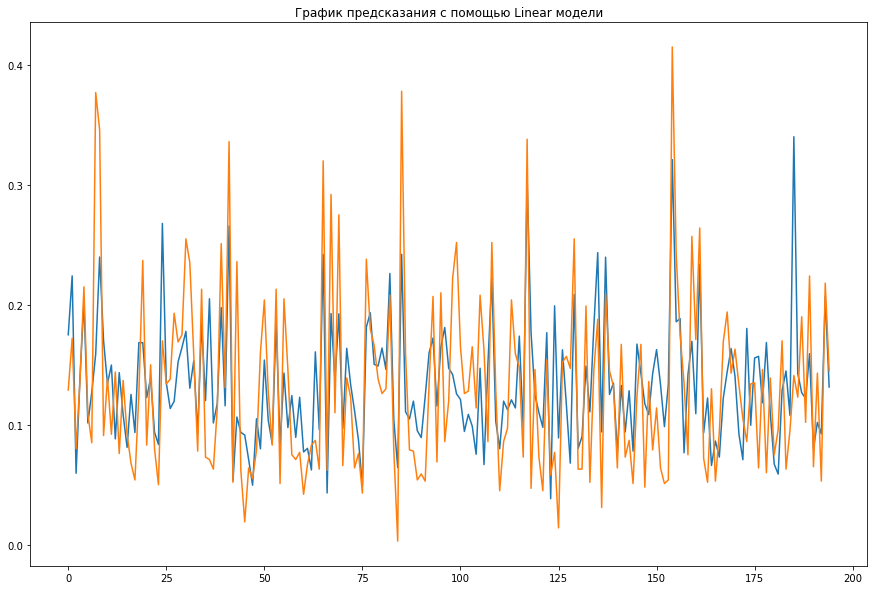

In [23]:
plt.figure(figsize=(15, 10))
plt.title('График предсказания с помощью Linear модели')

plt.plot(models['linear'].predict(X_test)[::5])
plt.plot(y_test.values[::5])
plt.savefig(f'{SOURCE_DIR}{FINAL_STAGE}linear_prediction.png')

plt.show()

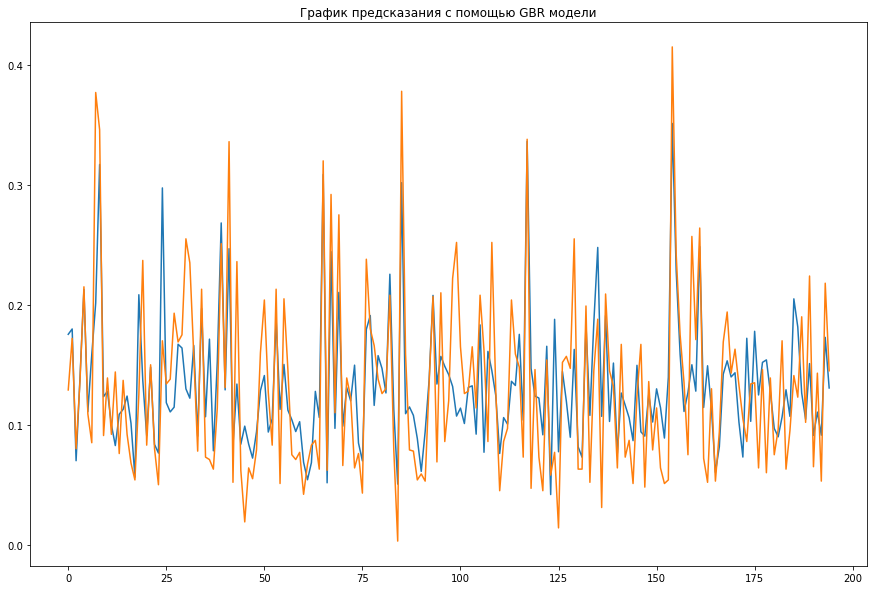

In [24]:
plt.figure(figsize=(15, 10))
plt.title('График предсказания с помощью GBR модели')

plt.plot(models['GBR'].predict(X_test)[::5])
plt.plot(y_test.values[::5])
plt.savefig(f'{SOURCE_DIR}{FINAL_STAGE}GBR_prediction.png')
plt.show()

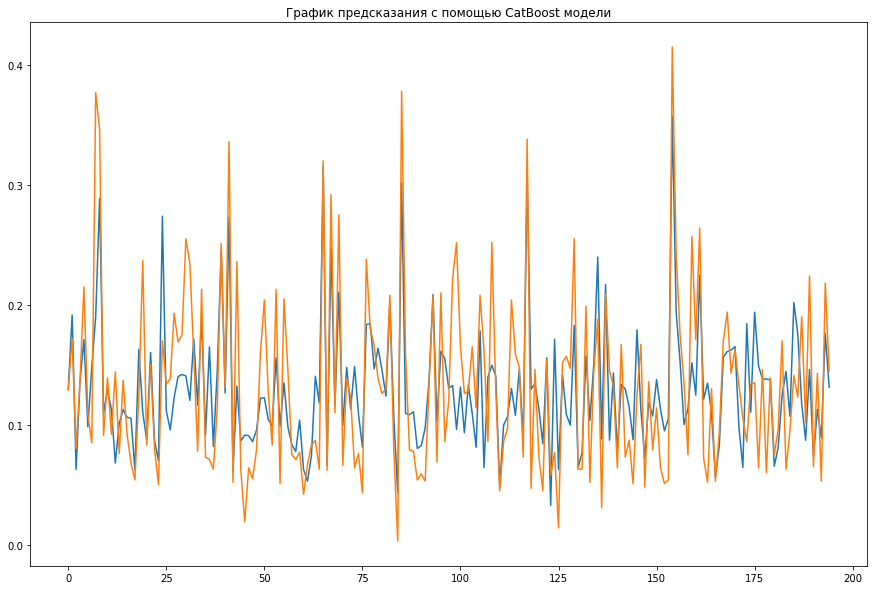

In [25]:
plt.figure(figsize=(15, 10))
plt.title('График предсказания с помощью CatBoost модели')

plt.plot(models['CatBoost'].predict(X_test)[::5])
plt.plot(y_test.values[::5])
plt.savefig(f'{SOURCE_DIR}{FINAL_STAGE}CatBoost_prediction.png')
plt.show()

